# Support Vector Machines (SVMs): From Intuition to Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

## 🚀 Section 1: The Quest for the Perfect Divider

### What is an SVM? (The Widest Street Analogy)

Imagine we are plotting data from a study on breast cancer tumors. For each tumor, we have features like 'mean radius' and 'mean texture'. Our goal is to classify tumors as either *malignant* or *benign*.

If we plot these data points, we might see two distinct clusters, or "neighborhoods." Many algorithms, like Logistic Regression, could find a line to separate these neighborhoods. But an SVM asks a more ambitious question: **What is the *best* possible line?**

An SVM's goal is not just to find *a* dividing line, but to find the line that is as far as possible from the closest data points of both classes. This gives us the **widest possible street** (the "margin") between the two neighborhoods.

This approach is called finding the **Maximum Margin Classifier**.

Key Terms:
- **Decision Boundary:** The line (or more generally, hyperplane) that sits in the middle of the street, separating the classes.
- **Margin:** The width of the street. A wider margin means the classifier is more confident and likely to generalize better to new, unseen data.
- **Support Vectors:** The data points (the "houses") that are closest to the street. These are the critical points that "support" or define the position and orientation of the decision boundary. If any other point were removed, the boundary would not change. But if a support vector is moved, the street might shift.

### Why Were SVMs Created? (A Bit of History & Motivation)

Support Vector Machines, developed by Vladimir Vapnik and his colleagues in the 1990s, grew out of the field of Statistical Learning Theory. The primary motivation was to create a classifier with strong theoretical guarantees against **overfitting**.

Unlike algorithms that consider every single data point, SVMs possess an elegant efficiency: they focus only on the most difficult-to-classify points—the support vectors. By maximizing the margin, SVMs find a decision boundary that is maximally robust, making them less likely to be swayed by noise or random fluctuations in the training data.

### When Should You Use an SVM? (Practical Use-Cases)

SVMs are a powerful tool in any machine learning practitioner's arsenal, especially for:
- **Binary Classification:** They are naturally suited for problems with two classes.
- **High-Dimensional Data:** SVMs perform remarkably well when the number of features is large, such as in text classification or bioinformatics.
- **Small-to-Medium Datasets:** They are very effective when the dataset is not massive, as the complexity of the optimization can grow with the number of samples.

## 🧠 Section 2: The Core Mathematics

Let's load our dataset to make the math tangible. We'll use the Breast Cancer Wisconsin dataset, which is conveniently included in Scikit-learn.

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target

# For SVMs, we typically want our classes to be -1 and 1.
# The dataset uses 0 (malignant) and 1 (benign). We'll convert 0s to -1s.
y = np.where(y == 0, -1, 1)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {data.feature_names[:5]}...")
print(f"Classes: {np.unique(y)}")

Feature matrix shape: (569, 30)
Target vector shape: (569,)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']...
Classes: [-1  1]


### The Hyperplane

In a 2D space, the decision boundary is a line. In 3D, it's a plane. In higher dimensions, it's called a **hyperplane**. The equation for this hyperplane is:

$$ w \cdot x - b = 0 $$

Where:
- $x$: Is a vector representing a single data point. In our case, `x` is a single tumor's features, like `[17.99, 10.38, ..., 0.2654]`.
- $w$: Is the **weight vector**. It's a vector of the same dimension as $x$. It determines the orientation of the hyperplane. The SVM's job is to find the optimal $w$.
- $b$: Is the **bias term**, a scalar that shifts the hyperplane away from the origin.

### Defining the Margin

The decision boundary is the center of our "street." The two gutters of the street, which touch the support vectors, are defined by two other hyperplanes:

$$ w \cdot x - b = 1 \quad \text{(for the positive class, benign)} $$
$$ w \cdot x - b = -1 \quad \text{(for the negative class, malignant)} $$

For any tumor $x_i$ with its true label $y_i$ (where $y_i$ is +1 for benign, -1 for malignant), we want the classifier to correctly place it on the right side of the margin. This gives us the core constraint of SVMs:

$$ y_i(w \cdot x_i - b) \ge 1 $$

This single equation elegantly ensures that all points are correctly classified and lie outside the margin.

It can be shown that the distance between these two margin boundaries—the width of the street—is exactly $ \frac{2}{\||w\|} $. To make this margin as wide as possible, we must make the length of the weight vector, $ \|w\| $, as small as possible. Specifically, we want to **minimize $ \|w\|^2 $** (we use the square because it's easier to differentiate).

### The Optimization Problem (Primal and Dual Form)

This leads us to the formal optimization problem for a **hard-margin SVM** (one that allows no errors). This is known as the **primal form**:


$$ \text{Minimize} \quad  \frac{1}{2}\|w\|^2 $$
$$ \text{subject to} \quad y_i(w \cdot x_i - b) \ge 1 \quad \text{for all } i=1, ..., n $$

Solving this constrained optimization problem directly is hard. We can reformulate it using **Lagrange Multipliers**, a powerful mathematical technique. This reformulation is called the **dual form**. While the full derivation is beyond our scope here, the key insight is that the dual form's solution depends only on the **dot products of the support vectors ($x_i \cdot x_j$)**. This is a crucial property that unlocks the Kernel Trick.

### Soft Margins & The Hinge Loss

What if the data isn't perfectly separable? What if a malignant tumor is located deep inside the benign neighborhood? A hard-margin SVM would fail.

To solve this, we introduce a **soft margin**, which allows some data points to be misclassified or to fall inside the margin. We add a *slack variable* $\xi_i$ for each point, representing how much that point violates the margin. 

We also introduce a new hyperparameter, $C$, which is the **cost of misclassification**. It controls the trade-off between maximizing the margin and minimizing the classification error.

- **High `C`**: The SVM tries to classify every single example correctly, even if it means having a very narrow margin. This can lead to overfitting.
- **Low `C`**: The SVM prefers a wide, generalizable margin, even if it means a few training examples are misclassified. This can lead to underfitting.

This trade-off is often expressed via the **Hinge Loss** function, which we will use in our from-scratch implementation.

### The Kernel Trick (Going Non-Linear)

What if a straight line simply can't separate our tumor data? The **Kernel Trick** is a brilliant mathematical maneuver that allows SVMs to create complex, non-linear decision boundaries.

The idea is to project the data into a higher-dimensional space where it *becomes* linearly separable. Imagine a 1D dataset that is not separable. By mapping it to 2D (e.g., using a function $\phi(x) = [x, x^2]$), we can easily draw a line to separate the classes.

The "trick" is that we don't actually have to perform this computationally expensive transformation. Because the SVM dual form only depends on dot products ($x_i \cdot x_j$), we can replace that dot product with a **kernel function** $K(x_i, x_j)$ that calculates what the dot product *would have been* in the higher-dimensional space. 

Common kernels include:
- **Linear:** $K(x_i, x_j) = x_i^T x_j$
- **Polynomial:** $K(x_i, x_j) = (\gamma x_i^T x_j + r)^d$
- **Radial Basis Function (RBF):** $K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$ (The default and most powerful)

## ⚙️ Section 3: The SVM Algorithm in Action (High-Level Process)

Here is a step-by-step breakdown of how an SVM trains, framed with our Breast Cancer dataset.

1.  **Input Data:** The algorithm receives the feature matrix `X` (30 measurements for each tumor) and the label vector `y` (-1 for malignant, 1 for benign).

2.  **Choose Hyperparameters:** The engineer selects a kernel (e.g., `'linear'`) and a `C` value (e.g., `C=1.0`). These choices guide the learning process.
3.  **Solve the Optimization Problem:** The SVM algorithm uses a numerical optimization technique (like Sequential Minimal Optimization, SMO) to solve the dual problem. This process finds the optimal **Lagrange multipliers** ($\alpha_i$) for each data point.

4.  **Identify Support Vectors:** After optimization, the algorithm inspects the multipliers. The data points (tumors) for which $\alpha_i > 0$ are the **support vectors**. All other points have $\alpha_i = 0$ and are henceforth ignored by the model.

5.  **Calculate `w` and `b`:** The optimal weight vector $w$ is calculated as a weighted sum of *only* the support vectors: $w = \sum_i \alpha_i y_i x_i$. The bias $b$ is then determined using this $w$ and the support vectors.

6.  **Output the Model:** The final, trained model is remarkably compact. It consists of only the support vectors, their corresponding $\alpha_i$ values, and the bias $b$. It doesn't need to store the entire dataset.

7.  **Prediction:** To classify a *new* tumor ($x_{new}$), the model computes the sign of the decision function: $\text{sign}(w \cdot x_{new} - b)$. If the result is +1, it's classified as benign; if -1, it's malignant.

## 🛠️ Section 4: Building an SVM from Scratch (Pure Python)

To truly understand the mechanics, we will now build a simplified Linear SVM using only NumPy. We'll use Gradient Descent for optimization because it's more intuitive than the complex quadratic programming solvers used in libraries like Scikit-learn.

Our goal is to find the best `w` and `b` by minimizing a loss function.

### The Hinge Loss + Regularization

The loss function for a soft-margin SVM is:

$$ L(w, b) = \lambda \|w\|^2 + \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - y_i(w \cdot x_i - b)) $$

This function has two parts:
1.  **Regularization Term ($ \lambda \|w\|^2 $):** This is the part that pushes for a small weight vector $w$, which is equivalent to pushing for a **wide street (margin)**. The hyperparameter $\lambda$ controls how much we prioritize the margin width. It's inversely related to the `C` parameter (i.e., `lambda` is like `1/C`).
2.  **Hinge Loss (the `max(0, ...)` term):** This part penalizes the model for errors. For a given point $x_i$, if it's correctly classified and outside the margin (i.e., $y_i(w \cdot x_i - b) \ge 1$), the loss for that point is 0. If it violates this condition (it's inside the margin or misclassified), the loss is $1 - y_i(w \cdot x_i - b)$, a value proportional to how far on the wrong side it is.

We will calculate the gradients of this loss function with respect to `w` and `b` and use them to update our parameters iteratively.

Now we define our `SimpleSVM` class.

In [3]:
class SimpleSVM:
    """
    A simplified implementation of a linear Support Vector Machine classifier
    using Gradient Descent to minimize the Hinge Loss.
    """
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.w = np.zeros(n_features)
        self.b = 0

        # Gradient Descent
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                y_i = y[idx]
                # This is the condition y_i * (w.x_i - b) >= 1
                condition = y_i * (np.dot(x_i, self.w) - self.b) >= 1
                
                if condition:
                    # Gradient of the regularization term
                    dw = 2 * self.lambda_param * self.w
                    db = 0
                else:
                    # Gradient of both regularization and loss term
                    dw = 2 * self.lambda_param * self.w - np.dot(x_i, y_i)
                    db = -y_i
                
                # Update rule
                self.w -= self.lr * dw
                self.b -= self.lr * db

    def predict(self, X):
        # Predictions are based on the sign of the decision function
        linear_output = np.dot(X, self.w) - self.b
        return np.sign(linear_output).astype(int)


### Training our SimpleSVM

Let's train our custom SVM on the data. It's **critical** to scale the features first. SVMs are not scale-invariant, as the optimization process is sensitive to the magnitude of the features.

In [4]:
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Instantiate and train our model
custom_svm = SimpleSVM()
custom_svm.fit(X_train_scaled, y_train)

# 4. Make predictions and evaluate
predictions = custom_svm.predict(X_test_scaled)

# The predict function can return 0 for points on the boundary, let's map them to 1
predictions[predictions == 0] = 1

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of our SimpleSVM: {accuracy * 100:.2f}%")

Accuracy of our SimpleSVM: 44.74%


## ✅ Section 5: The Easy Way (Implementation with Scikit-learn)

While building from scratch is enlightening, in practice we use highly optimized libraries like Scikit-learn. The workflow is much simpler.

### Linear SVM with Scikit-learn

--- Scikit-learn Linear SVM Results ---
Accuracy: 95.61%

Classification Report:
                precision    recall  f1-score   support

Malignant (-1)       0.93      0.95      0.94        43
    Benign (1)       0.97      0.96      0.96        71

      accuracy                           0.96       114
     macro avg       0.95      0.96      0.95       114
  weighted avg       0.96      0.96      0.96       114


Confusion Matrix:


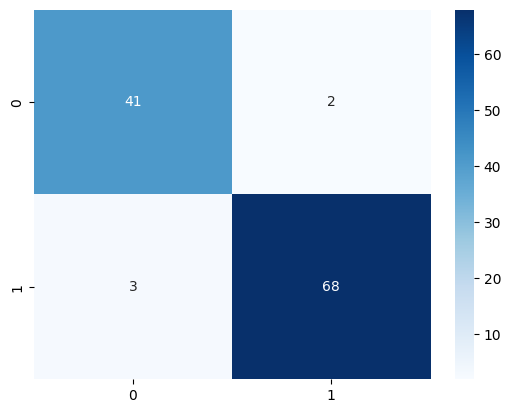

In [5]:
# Instantiate the model. C is the regularization parameter (inversely related to our lambda_param).
svc_linear = SVC(kernel='linear', C=1.0)

# Train the model using the same scaled data
svc_linear.fit(X_train_scaled, y_train)

# Make predictions
y_pred_linear = svc_linear.predict(X_test_scaled)

print("--- Scikit-learn Linear SVM Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_linear) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_linear, target_names=['Malignant (-1)', 'Benign (1)']))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_linear), annot=True, fmt='d', cmap='Blues')
plt.show()

### Non-Linear (RBF Kernel) SVM with Scikit-learn

Now let's see if a non-linear kernel can perform even better on this dataset.

--- Scikit-learn RBF Kernel SVM Results ---
Accuracy: 98.25%

Classification Report:
                precision    recall  f1-score   support

Malignant (-1)       1.00      0.95      0.98        43
    Benign (1)       0.97      1.00      0.99        71

      accuracy                           0.98       114
     macro avg       0.99      0.98      0.98       114
  weighted avg       0.98      0.98      0.98       114


Confusion Matrix:


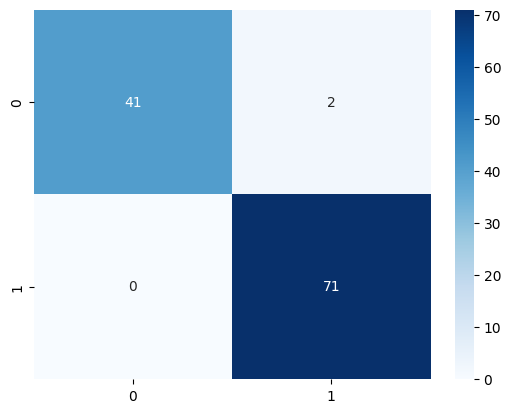

In [6]:
# The 'rbf' kernel is the default
svc_rbf = SVC(kernel='rbf', C=1.0, gamma='scale') # 'gamma' is a key hyperparameter for RBF

# Train the model
svc_rbf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rbf = svc_rbf.predict(X_test_scaled)

print("--- Scikit-learn RBF Kernel SVM Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rbf, target_names=['Malignant (-1)', 'Benign (1)']))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_rbf), annot=True, fmt='d', cmap='Blues')
plt.show()

## 📊 Section 6: Hyperparameter Tuning and Visualization

The performance of an SVM is highly dependent on its hyperparameters. Let's visualize how they affect the decision boundary.

Key Hyperparameters for `SVC`:
- **`C`**: The regularization parameter. It trades off correct classification of training examples against maximization of the decision boundary's margin. A low `C` makes for a smooth decision surface (wide margin), while a high `C` aims at classifying all training examples correctly (narrow margin), potentially overfitting.
- **`gamma`**: The kernel coefficient for 'rbf'. It defines how much influence a single training example has. A low value means 'far' and a high value means 'close'. A high gamma can lead to overfitting by creating complex boundaries that are too specific to the training data.

To visualize the boundary, we need to reduce our 30-dimensional data to 2 dimensions. We'll use Principal Component Analysis (PCA) for this.

First, let's create our 2D data and a helper function to plot the decision boundaries.

In [7]:
# Reduce data to 2 dimensions for visualization
pca = PCA(n_components=2)
X_scaled = scaler.transform(X) # Use the full, scaled dataset
X_pca = pca.fit_transform(X_scaled)

def plot_decision_boundary(clf, X, y, title):
    """Plots the decision boundary for a classifier on 2D data."""
    plt.figure(figsize=(8, 6))
    
    # Create a meshgrid to evaluate the model
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Get predictions for the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and the training points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Malignant', 'Benign'])
    plt.show()

### Visualizing the Effect of `C` (with a Linear Kernel)

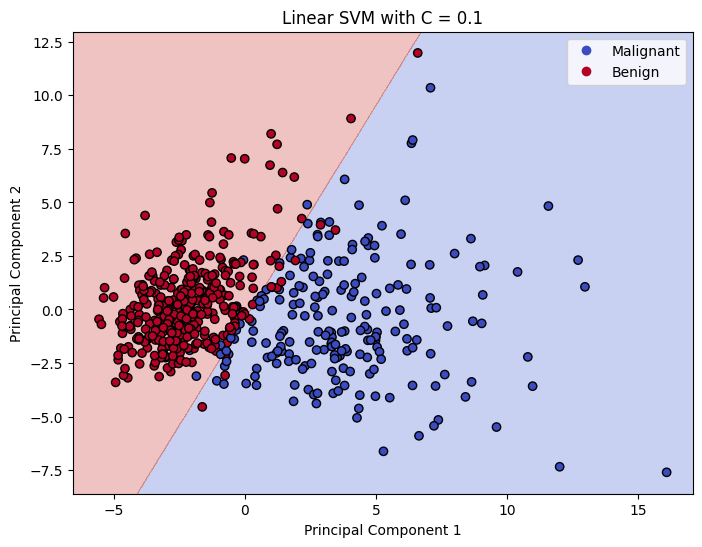

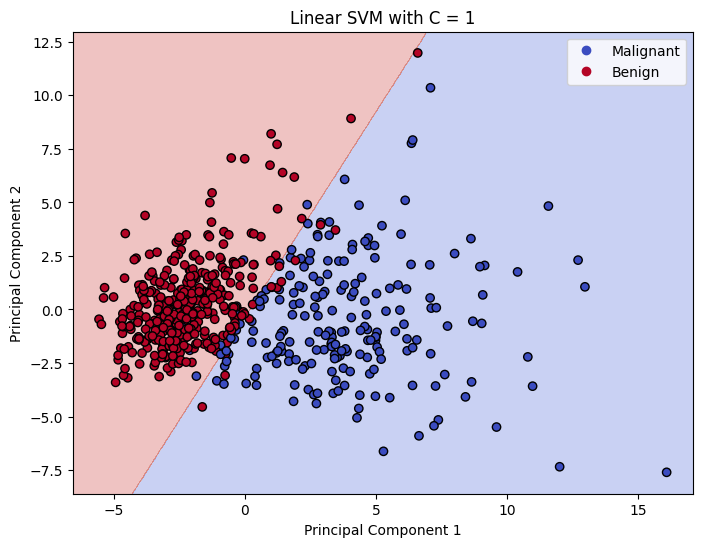

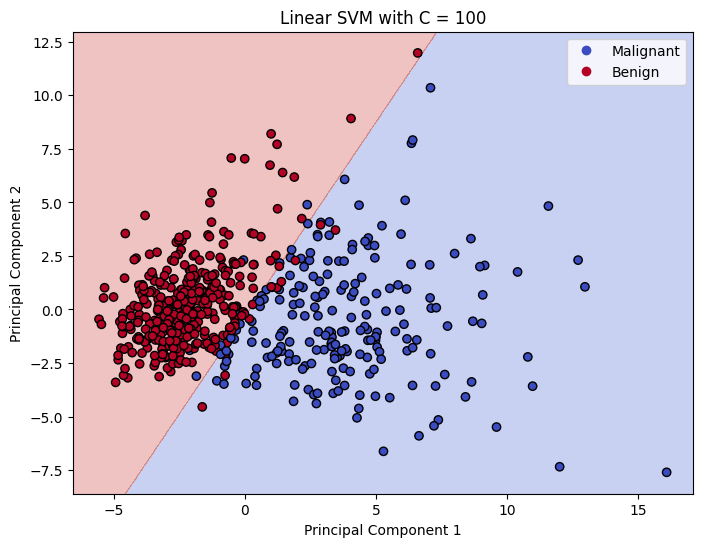

In [8]:
for c_val in [0.1, 1, 100]:
    # Train a linear SVM with the current C value
    clf = SVC(kernel='linear', C=c_val)
    clf.fit(X_pca, y)
    plot_decision_boundary(clf, X_pca, y, title=f'Linear SVM with C = {c_val}')

As you can see, a small `C` value creates a wider margin and may misclassify a few points. A large `C` value tries to classify everything correctly, resulting in a much narrower margin.

### Visualizing the Effect of `gamma` (with an RBF Kernel)

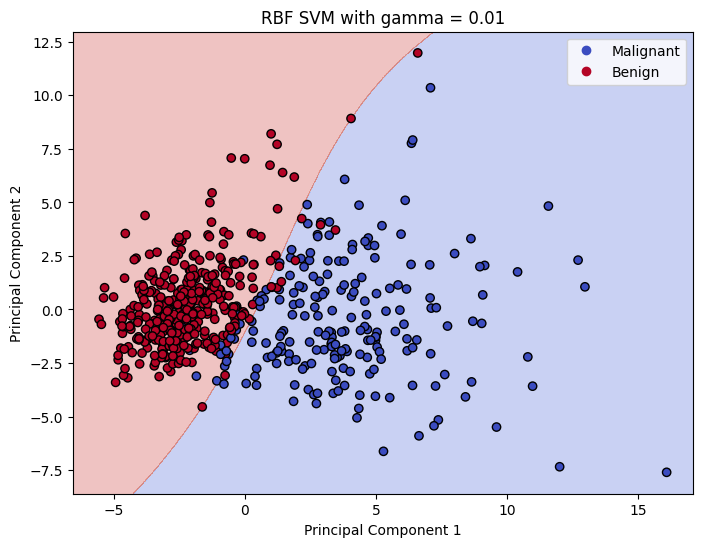

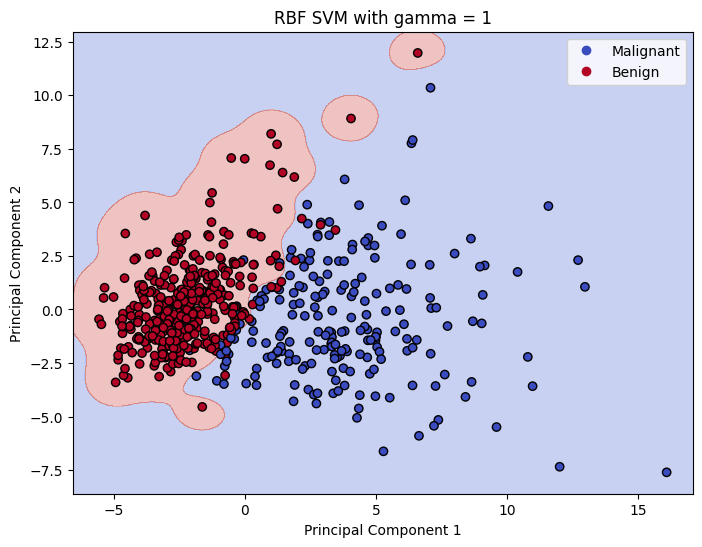

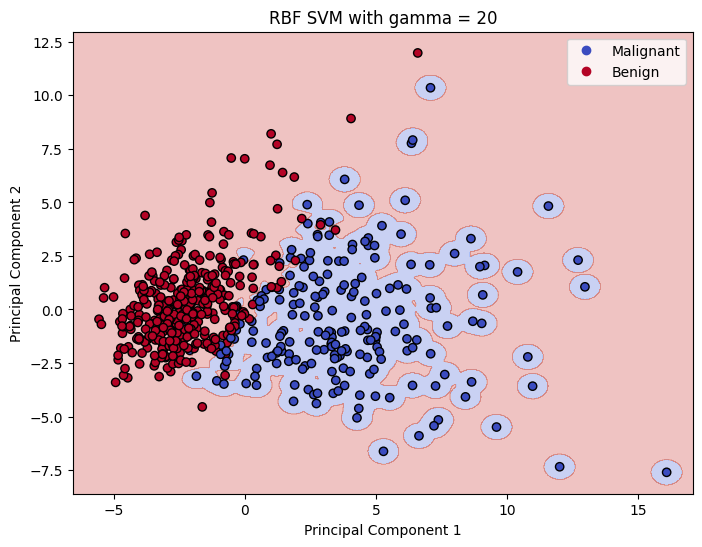

In [11]:
for gamma_val in [0.01, 1, 20]:
    # Train an RBF SVM with the current gamma value
    clf = SVC(kernel='rbf', gamma=gamma_val, C=1.0)
    clf.fit(X_pca, y)
    plot_decision_boundary(clf, X_pca, y, title=f'RBF SVM with gamma = {gamma_val}')

Here, a small `gamma` gives a very smooth, broad decision boundary. As `gamma` increases, the boundary becomes highly complex and contorted to fit the training data perfectly, a clear sign of overfitting.

## 🎓 Section 7: Conclusion

In this notebook, we have journeyed through the world of Support Vector Machines. We began with the simple, intuitive idea of finding the "widest street" to separate our data. We then delved into the core mathematics that translates this idea into a constrained optimization problem.

By building a simplified SVM from scratch, we gained a deep appreciation for the mechanics of its loss function and how it learns. Finally, we used the powerful, production-ready implementation in Scikit-learn, exploring how to apply both linear and non-linear kernels and how to tune their hyperparameters visually.

**Key Takeaways:**
- **Margin Maximization:** The core principle of SVMs is to find a decision boundary that is maximally far from any data point, leading to robust generalization.
- **The Power of Kernels:** The kernel trick allows SVMs to efficiently create highly non-linear decision boundaries without explicitly transforming the data.
- **The Importance of Hyperparameters:** The `C` and `gamma` parameters are crucial knobs that control the model's complexity and its bias-variance trade-off. Proper tuning is essential.
- **Don't Forget to Scale:** SVMs are sensitive to feature scales, so scaling your data with `StandardScaler` is a mandatory preprocessing step.

SVMs remain a powerful and relevant tool, especially for classification tasks with high-dimensional features, and their theoretical elegance makes them a cornerstone of classical machine learning.